# Chapter 7: Fitting a Gaussian Process Model to Natural Gas Forward Curve

This notebook implements a Gaussian Process model for constructing a forward curve. Specifically, we consider constructing the forward curve for NYMEX Henry Hub Natural Gas contracts. These contracts have monthly delivery periods and maturities of 1-150 months, though only a fraction of these maturities are liquid at any given point in time. 

For this illustration, we ignore the issue of having a delivery *period* rather than a delivery date, in other words we will construct a forward curve that represents contracts with payoff $\int_{T_1}^{T_1+1} S_t dt$ where $(S_t)$ is the underlying spot natural gas price and $T_1$ is the number of months until beginning of the delivery period. The data to be used was downloaded from [barchart.com](https://www.barchart.com/futures/quotes/NG*0/futures-prices?viewName=main)

This notebook reproduces Figure 7.2 in the book, see respective Section 7.2. Our primary focus is on constructing an expressive additive GP kernel which captures the strong annual seasonality in natural gas.

We implement the Gaussian process model in [TensorFlow Probability](https://www.tensorflow.org/probability/) which allows to easily implement and tune a custom kernel.

In [1]:
# Imports
import os
from itertools import islice

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
os.chdir("C:/Users/Mike Ludkovski/Dropbox/Mike/GP Book/labs/Python")
ng = pd.read_csv('natural-gas-prices-intraday-09-11-2024.csv', header=0, usecols=[1,7,8,9], parse_dates=['Time'], date_format='%m/%d/%Y')
ng = ng[1:148]
ng["DateNum"] = np.arange(2024+9./12,2037,1/12.)
ng.head()    

,Last,Volume,Open Int,Time,DateNum
1,2.232,2125.0,223835.0,23:56 CT,2024.750000
2,2.536,640.0,0.0,23:49 CT,2024.833333
3,3.020,126.0,0.0,23:39 CT,2024.916667
4,3.308,206.0,0.0,23:39 CT,2025.000000
5,3.190,13.0,0.0,21:49 CT,2025.083333


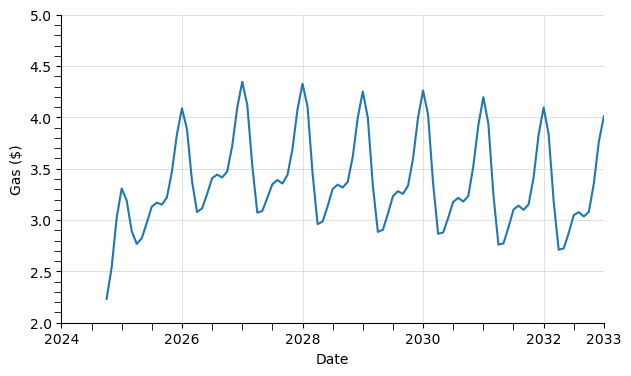

In [3]:
plt.figure(figsize=(7, 4))

# Create the line plot using seaborn
sns.lineplot(x=ng.DateNum, y=ng.Last,linewidth=1.5)

# Set axis labels and limits
plt.xlabel('Date')
plt.ylabel('Gas ($)')
plt.xlim(2024, 2033)
plt.ylim(2, 5)

plt.xticks([2024, 2026, 2028, 2030, 2032, 2033])
plt.grid(which='both', linewidth=0.5, color='lightgray')  # Customize as needed
plt.grid(which='minor', alpha=0)
plt.tick_params(which='minor', length=5)

# Remove plot borders
sns.despine()
# Add minor ticks
plt.minorticks_on()

# Display the plot
plt.show()

## Training and Test data

We will use liquid quotes as training data and the rest as test data. The idea is that market makers have to quote all 150 maturities, but these are just phantom quotes and quantitative analysts desire their own model-based estimates. To do so, they calibrate to the *trustworthy* quotes namely those where actual trades recently occured. 

Below we split according to whether the daily trading volume was of at least 2 contracts. We see that the first 33 months are liquid (so almost 3 years, but after that liquidity is roughly quarterly. None of the quotes beyond 52 months are liquid. 

In [4]:
df_observed = ng[  (ng["Volume"]>2) ]

print('{} contracts in the observed set'.format(len(df_observed)))
df_observed

37 contracts in the observed set


,Last,Volume,Open Int,Time,DateNum
1,2.232,2125.0,223835.0,23:56 CT,2024.750000
2,2.536,640.0,0.0,23:49 CT,2024.833333
3,3.020,126.0,0.0,23:39 CT,2024.916667
4,3.308,206.0,0.0,23:39 CT,2025.000000
5,3.190,13.0,0.0,21:49 CT,2025.083333
6,2.891,13.0,0.0,23:39 CT,2025.166667
7,2.768,14.0,0.0,20:54 CT,2025.250000
8,2.822,8.0,0.0,23:39 CT,2025.333333
9,2.974,3337.0,29427.0,2024-09-10,2025.416667
10,3.131,2783.0,19286.0,2024-09-10,2025.500000


## Gaussian process kernel construction

Recall that in our notation, a Gaussian process is uniquely defined by its mean function $m(x)$ and covariance function $k(x,x')$:

$$f(x) \sim \mathcal{GP}(m(x),k(x,x'))$$

For the **mean function**  we will just take the average observed NG forward price.

In [5]:
# Define mean function as the mean of observations
observations_mean = tf.constant(
    [np.mean(df_observed.Last.values)], dtype=tf.float64)
mean_fn = lambda _: observations_mean

**Covariance kernel**: to model the characteristics of the NG dataset we create an additive covariance (kernel) function, utilizing  kernels already available in [TensorFlow-Probability](https://www.tensorflow.org/probability/api_docs/python/tfp/math/psd_kernels/PositiveSemidefiniteKernel). The respective terms are:

- Long term smooth change in NG prices over time modelled by a [squared-exponential (SE)](https://www.tensorflow.org/probability/api_docs/python/tfp/math/psd_kernels/ExponentiatedQuadratic) kernel defined in the code below as `smooth_kernel` (can also be replaced with Rational Quadratic term).
- Seasonality based on a periodic kernel, namely an [exponentiated sine squared kernel](https://www.tensorflow.org/probability/api_docs/python/tfp/math/psd_kernels/ExpSinSquared), see `periodic_kernel`.
- Observational noise which will be modelled directly by the `observation_noise_variance` parameter of the [TensorFlow Gaussian process model](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcess).

These different kernels will be summed into one single kernel function $k_{\theta}(x_a, x_b)$ that will allow for all these effects to occur together. This kernel is defined as `kernel` in the code below. Each of the kernels has hyperparameters $\theta$ that can be tuned, they will be defined as a variable so they can be fitted on the observed data. 

**Note**:

1. We use `float64` datatype to mitigate numerical issues when computing the Cholesky decomposition of the kernel matrix 

2. Most hyperparameters are constrained to be strictly positive using `bijector=constrain_positive`

3.  Using TensorFlow Probability [distributions](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions) one can define a prior distribution for each hyperparameter and use the log-likelihood of that distribution as a regularization term

In [6]:
# Define the kernel with trainable parameters. 
# Constrain to make sure certain parameters are strictly positive
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

# Smooth kernel hyperparameters
smooth_amplitude = tfp.util.TransformedVariable(
    initial_value=1., bijector=constrain_positive, dtype=np.float64,
    name='smooth_amplitude')
smooth_length_scale = tfp.util.TransformedVariable(
    initial_value=2., bijector=constrain_positive, dtype=np.float64,
    name='smooth_length_scale')
# Smooth kernel
smooth_kernel = tfk.ExponentiatedQuadratic(
    amplitude=smooth_amplitude, 
    length_scale=smooth_length_scale)
# Can also try 
#tfk.RationalQuadratic(
#    amplitude=smooth_amplitude,
#    length_scale=smooth_length_scale,
#    scale_mixture_rate=rq_scale_mixture)


# Periodic kernel hyperparameters
periodic_amplitude = tfp.util.TransformedVariable(
    initial_value=0.5, bijector=constrain_positive, dtype=np.float64,
    name='periodic_amplitude')
periodic_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, dtype=np.float64,
    name='periodic_length_scale')
periodic_period = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, dtype=np.float64,
    name='periodic_period')
periodic_kernel = (
    tfk.ExpSinSquared(
        amplitude=periodic_amplitude, 
        length_scale=periodic_length_scale,
        period=periodic_period) ) 

# Noise variance of observations
observation_noise_variance = tfp.util.TransformedVariable(
    initial_value=0.0001, bijector=constrain_positive, dtype=np.float64,
    name='observation_noise_variance')

trainable_variables = [v.variables[0] for v in [
    smooth_amplitude,
    smooth_length_scale,
    periodic_amplitude,
    periodic_length_scale,
#    periodic_period,      # Period is not trained, fixed at 1 year
    observation_noise_variance
]]


# Sum to a single kernel containing all characteristics
kernel = (smooth_kernel + periodic_kernel )

### Tuning the hyperparameters

We tune the hyperparameters $\theta$ of our model by maximizing the marginal likelihood  $p(\mathbf{y} \mid X, \theta)$ of the Gaussian process distribution based on the observed data $(X, \mathbf{y})$.

$$\hat{\theta}  = \underset{\theta}{\text{argmax}} \log  p(\mathbf{y} \mid X, \theta)  = \underset{\theta}{\text{argmin}} \Bigl(\frac{1}{2}(\mathbf{y} + \mu_{\theta})^\top \Sigma_{\theta}^{-1} (\mathbf{y} - \mu_{\theta}) + \frac{1}{2} \log{\lvert \Sigma_{\theta} \rvert} + \frac{d}{2} \log{2 \pi} \Bigr) $$

where we emphasize that the log likelihood is parametrized by the kernel hyperaparameters. The first term $ \frac{-1}{2} (\mathbf{y} - \mu_{\theta})^\top \Sigma_{\theta}^{-1} (\mathbf{y} - \mu_{\theta})$ is the data-fit while the rest $ \frac{-1}{2}(\log{\lvert \Sigma_{\theta} \rvert} + d\log{2 \pi})$ is a complexity penalty.

The optimal parameters $\hat{\theta}$ are inferred by minimizing the negative of the log marginal likelihood (NLL) using a gradient based approach based on minibatches of the observed data. To do so we leverage **TensorFlow**. 

In [7]:
# Define mini-batch data iterator
batch_size = 32

batched_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (df_observed.DateNum.values.reshape(-1, 1), df_observed.Last.values))  # training set
    .shuffle(buffer_size=len(df_observed))
    .repeat(count=None)
    .batch(batch_size)
)

The Gaussian process marginal distribution is represented by the [`GaussianProcess`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcess) object which has a `log_prob` function to get the marginal log likelihood. The [`AdamOptimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) is used to minimize the negative marginal log likelihood. The stochastic gradient descent uses fixed batches of `batch_size=32` training inputs for `nb_iterations=6000` steps.

In [8]:
# Use tf.function for more efficient function evaluation
@tf.function(autograph=False, experimental_compile=False)
def gp_loss_fn(index_points, observations):
    """Gaussian process negative-log-likelihood loss function."""
    gp = tfd.GaussianProcess(
        mean_fn=mean_fn,
        kernel=kernel,
        index_points=index_points,
        observation_noise_variance=observation_noise_variance
    )
    
    negative_log_likelihood = -gp.log_prob(observations)
    return negative_log_likelihood

In [9]:
# Fit hyperparameters using Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
batch_nlls = []  # Batch NLL for plotting
full_ll = []  # Full data NLL for plotting
nb_iterations = 6001
for i, (index_points_batch, observations_batch) in enumerate(islice(batched_dataset, nb_iterations)):
    # Run optimization for single batch
    with tf.GradientTape() as tape:
        loss = gp_loss_fn(index_points_batch, observations_batch)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    batch_nlls.append((i, loss.numpy()))
    # Evaluate on all observations
    if i % 100 == 0:
        ll = gp_loss_fn(
            index_points=df_observed.DateNum.values.reshape(-1, 1),
            observations=df_observed.Last.values)
        full_ll.append((i, ll.numpy()))

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


The next diagnostic plot shows the batch and full log likekihood over the SGD steps, visualizing the respective convergence.

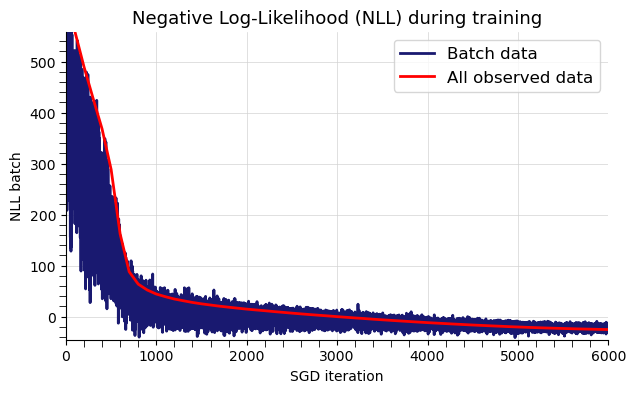

In [10]:
iterations_batch, nll_batch = zip(*batch_nlls)
iterations_full, nll_full = zip(*full_ll)

# Create a figure
plt.figure(figsize=(7, 4))

# First plot: Batch data
sns.lineplot(x=iterations_batch, y=nll_batch, label='Batch data', 
             color='midnightblue', linewidth=2)

# Second plot: All observed data
sns.lineplot(x=iterations_full, y=nll_full, label='All observed data', 
             color='red', linewidth=2)

# Set axis labels and title
plt.xlabel('SGD iteration')
plt.ylabel('NLL batch')
plt.title('Negative Log-Likelihood (NLL) during training', fontsize=13)

# Set axis limits
plt.xlim(0, nb_iterations)
plt.ylim(nll_full[-1]-20, nll_full[1])
plt.grid(which='both', linewidth=0.5, color='lightgray')  # Customize as needed
plt.grid(which='minor', alpha=0)
plt.tick_params(which='minor', length=5)

# Remove plot borders
sns.despine()
# Add minor ticks
plt.minorticks_on()
plt.legend(loc='upper right', fontsize=12)

plt.show()

In [11]:
# Show values of parameters found
variables = [
    smooth_amplitude,
    smooth_length_scale,
    periodic_amplitude,
    periodic_length_scale,
    observation_noise_variance
]

data = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
df_variables = pd.DataFrame(
    data, columns=['Hyperparameters', 'Value'])
df_variables

,Hyperparameters,Value
0,smooth_amplitude,0.4940868419790565
1,smooth_length_scale,0.49077350175937373
2,periodic_amplitude,0.574906348731179
3,periodic_length_scale,1.323783266014019
4,observation_noise_variance,0.000654875980979714


## Fitted Forward Curve

To make predictions, we create a [`GaussianProcessRegressionModel`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcessRegressionModel) with the fitted kernel, mean function and observed data. The estimated NG forward curve conditioned on the observed liquid quotes are plotted in the figure below together with their 95% prediction intervals. 

Notice that our model captures captures the different dataset characteristics such as the trend and seasonality quite well. The predictions start deviating the further away from the observed data the model was conditioned on, together with a widening prediction interval.

In [12]:
# Posterior GP using fitted kernel and observed data
df_to_predict = ng
gp_posterior_predict = tfd.GaussianProcessRegressionModel(
    mean_fn=mean_fn,
    kernel=kernel,
    index_points=df_to_predict.DateNum.values.reshape(-1, 1),
    observation_index_points=df_observed.DateNum.values.reshape(-1, 1),
    observations=df_observed.Last.values,
    observation_noise_variance=observation_noise_variance)

# GP Posterior mean and standard deviation
posterior_mean_predict = gp_posterior_predict.mean()
posterior_std_predict = gp_posterior_predict.stddev()

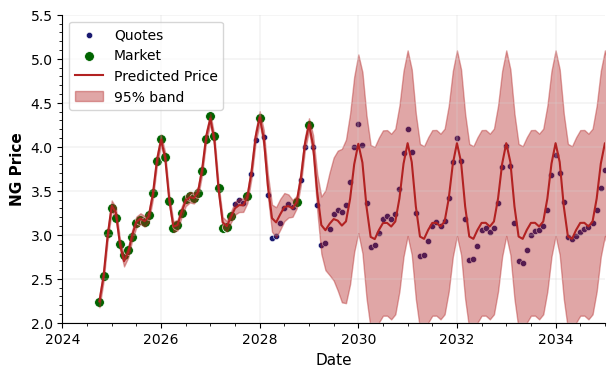

In [13]:
μ = posterior_mean_predict.numpy()
σ = posterior_std_predict.numpy()
plt.figure(figsize=(7, 4))
plt.grid(which='both', linewidth=0.3, color='lightgray') 
plt.grid(which='minor', alpha=0)

# Plot the market and quotes data
sns.scatterplot(x=df_to_predict.DateNum, y=df_to_predict.Last, 
                label='Quotes', color='midnightblue', s=20)
sns.scatterplot(x=df_observed.DateNum, y=df_observed.Last, 
                label='Market', color='darkgreen', s=50)

# Plot the predicted mean
sns.lineplot(x=df_to_predict.DateNum, y=μ, 
             label='Predicted Price', color='firebrick', linewidth=1.5)

# Compute the band (95% prediction interval)
band_x = np.append(df_to_predict.DateNum.values, df_to_predict.DateNum.values[::-1])
band_y = np.append(μ + 1.96 * σ, (μ - 1.96 * σ)[::-1])

# Plot the 95% prediction interval as a filled area
plt.fill_between(df_to_predict.DateNum, μ + 1.96 * σ, μ - 1.96 * σ, 
                 color='firebrick', alpha=0.4, label='95% band')

# Set axis labels and styling
plt.xlabel('Date', fontsize=11)
plt.ylabel('NG Price', fontsize=11, fontweight='bold')
plt.xlim(2024, 2035)
plt.ylim(2, 5.5)
plt.legend(loc='upper left', fontsize=10)

# Remove plot borders
sns.despine()
# Add minor ticks
plt.minorticks_on()
plt.show()

## References

1. [Gaussian Processes for Machine Learning. Chapter 5: Model Selection and Adaptation of Hyperparameters](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf) by Carl Edward Rasmussen and Christopher K. I. Williams.
2. [Gaussian Processes for Regression](https://papers.nips.cc/paper/1048-gaussian-processes-for-regression.pdf) by Christopher K. I. Williams and Carl Edward Rasmussen.
3. [Gaussian processes (3/3) - exploring kernels](https://peterroelants.github.io/posts/gaussian-process-kernels/) by Peter Roelants

In [ ]:
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#